### Import

In [36]:
import pandas as pd
import yfinance as yf
import talib 
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [116]:
df = pd.read_csv("./data/stocks/INTL.csv", sep=',')
df['Date'] = pd.to_datetime(df['Date'])
df.index = range(len(df))
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1995-03-06,2.253944,2.253944,2.253944,2.253944,2.253944,1300
1995-03-07,1.878287,2.066116,1.878287,1.878287,1.878287,5800
1995-03-08,1.878287,1.878287,1.878287,1.878287,1.878287,0
1995-03-09,1.878287,1.878287,1.878287,1.878287,1.878287,0
1995-03-10,1.878287,1.878287,1.878287,1.878287,1.878287,0


### TA indicators

In [117]:
df['SMA_10'] = talib.SMA(df['Close'], timeperiod=10)
df['SMA_20'] = talib.SMA(df['Close'], timeperiod=20)
df['EMA_20'] = talib.EMA(df['Close'], timeperiod=20)
df['RSI_14'] = talib.RSI(df['Close'], timeperiod=14)
df["Upper_BB"], df["Middle_BB"], df["Lower_BB"] = talib.BBANDS(df["Close"], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df['EMA_12'] = talib.EMA(df['Close'], timeperiod=12)
df['EMA_26'] = talib.EMA(df['Close'], timeperiod=26)
df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_10,SMA_20,EMA_20,RSI_14,Upper_BB,Middle_BB,Lower_BB,EMA_12,EMA_26,MACD,MACD_Signal,MACD_Hist
Date,,,,,,,,,,,,,,,,,,
1995-03-06,2.253944,2.253944,2.253944,2.253944,2.253944,1300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-07,1.878287,2.066116,1.878287,1.878287,1.878287,5800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-08,1.878287,1.878287,1.878287,1.878287,1.878287,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-09,1.878287,1.878287,1.878287,1.878287,1.878287,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-10,1.878287,1.878287,1.878287,1.878287,1.878287,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
df.fillna(method='ffill', inplace=True)  
#df.dropna(inplace=True)
data = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

if np.any(np.isnan(scaled_data)):
    print("Dữ liệu sau khi chuẩn hóa chứa NaN. Điền bằng 0.")
    scaled_data = np.nan_to_num(scaled_data, nan=0.0)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 90
X, y = create_sequences(scaled_data, seq_length)

train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

C:\Users\Admin\AppData\Local\Temp\ipykernel_9308\3361865249.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [124]:
model = Sequential([
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='mse',
             metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [125]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=200,
                    batch_size=32,
                    callbacks=[early_stop])

Epoch 1/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0352 - mae: 0.1341 - val_loss: 9.6667e-04 - val_mae: 0.0249
Epoch 2/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0014 - mae: 0.0274 - val_loss: 9.5847e-04 - val_mae: 0.0248
Epoch 3/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0011 - mae: 0.0200 - val_loss: 8.3454e-04 - val_mae: 0.0229
Epoch 4/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 7.8900e-04 - mae: 0.0172 - val_loss: 7.9007e-04 - val_mae: 0.0222
Epoch 5/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 8.0249e-04 - mae: 0.0171 - val_loss: 7.7561e-04 - val_mae: 0.0219
Epoch 6/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 7.5309e-04 - mae: 0.0163 - val_loss: 8.1815e-04 - val_mae: 0.0226
Epoch 7/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 6.7864e-04 - mae: 0.0162 - val_loss: 0.0013 - val_mae: 0.0302
Epoch 8/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 7.0181e-04 - mae: 0.0157 - val_loss: 0.0016 - val_mae: 0.0

In [126]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

if np.any(np.isnan(predictions)) or np.any(np.isnan(y_test_actual)):
    print("Dự đoán hoặc giá thực tế chứa NaN. Điền bằng 0.")
    predictions = np.nan_to_num(predictions, nan=0.0)
    y_test_actual = np.nan_to_num(y_test_actual, nan=0.0)

rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f'RMSE: {rmse}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE: 2.2329433012961073


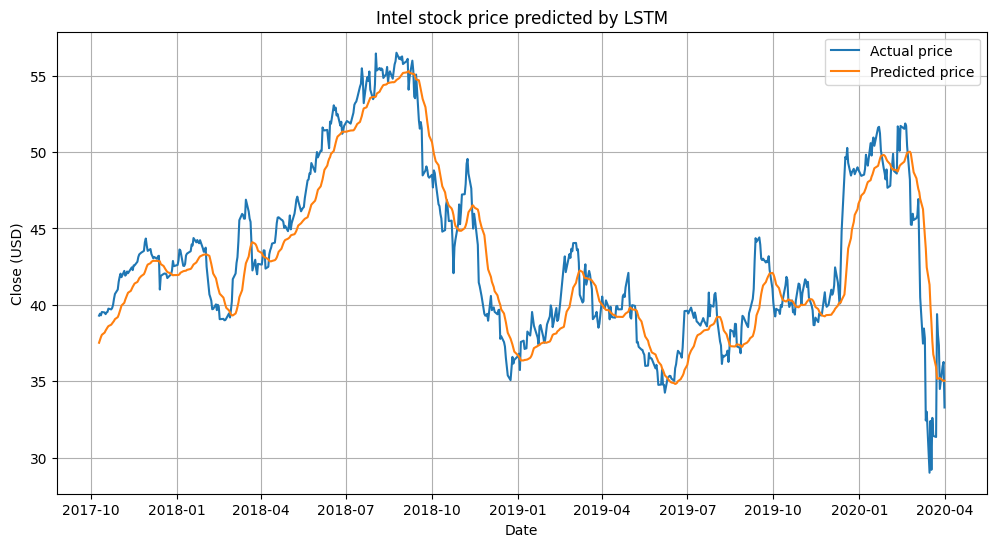

In [127]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test_actual, label='Actual price')
plt.plot(df.index[-len(predictions):], predictions, label='Predicted price')
plt.title('Intel stock price predicted by LSTM')
plt.xlabel('Date')
plt.ylabel('Close (USD)')
plt.legend()
plt.grid(True)
plt.show()